# Inteligencia Artificial - ESIS - UNJBG
## Semana 3: Modelos Lineales y Autodiferenciación 1/3
### Docente: MSc.(c) Israel N. Chaparro-Cruz

**Basado en: Week 1, Day 2: Linear Deep Learning, By Neuromatch Academy**

__Content creators:__ Saeed Salehi, Vladimir Haltakov, Andrew Saxe

__Content reviewers:__ Polina Turishcheva, Antoine De Comite, Kelson Shilling-Scrivo

__Content editors:__ Anoop Kulkarni, Spiros Chavlis

__Production editors:__ Khalid Almubarak, Spiros Chavlis

__Post-Production team:__ Gagana B, Spiros Chavlis

__Content Traduction:__ Israel N. Chaparro-Cruz

---
# Objetivos del Tutorial

Se continuará con la construcción del conjunto de habilidades de PyTorch y motivará su funcionalidad principal: Autograd. En este cuaderno, cubriremos los conceptos e ideas clave de:

* Descenso de gradientes
* PyTorch Autograd
* Módulo `nn` de PyTorch

---
# Configuración

Este es un tutorial sin GPU.

In [1]:
# Imports
import torch
import numpy as np
from torch import nn
from math import pi
import matplotlib.pyplot as plt

In [2]:
# @title Figure settings
import ipywidgets as widgets       # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

In [3]:
# @title Plotting functions

from mpl_toolkits.axes_grid1 import make_axes_locatable

def ex3_plot(model, x, y, ep, lss):
  """
  Plot training loss

  Args:
    model: nn.module
      Model implementing regression
    x: np.ndarray
      Training Data
    y: np.ndarray
      Targets
    ep: int
      Number of epochs
    lss: function
      Loss function

  Returns:
    Nothing
  """
  f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
  ax1.set_title("Regression")
  ax1.plot(x, model(x).detach().numpy(), color='r', label='prediction')
  ax1.scatter(x, y, c='c', label='targets')
  ax1.set_xlabel('x')
  ax1.set_ylabel('y')
  ax1.legend()

  ax2.set_title("Training loss")
  ax2.plot(np.linspace(1, epochs, epochs), losses, color='y')
  ax2.set_xlabel("Epoch")
  ax2.set_ylabel("MSE")

  plt.show()


def ex1_plot(fun_z, fun_dz):
  """
  Plots the function and gradient vectors

  Args:
    fun_z: f.__name__
      Function implementing sine function
    fun_dz: f.__name__
      Function implementing sine function as gradient vector

  Returns:
    Nothing
  """
  x, y = np.arange(-3, 3.01, 0.02), np.arange(-3, 3.01, 0.02)
  xx, yy = np.meshgrid(x, y, sparse=True)
  zz = fun_z(xx, yy)
  xg, yg = np.arange(-2.5, 2.6, 0.5), np.arange(-2.5, 2.6, 0.5)
  xxg, yyg = np.meshgrid(xg, yg, sparse=True)
  zxg, zyg = fun_dz(xxg, yyg)

  plt.figure(figsize=(8, 7))
  plt.title("Gradient vectors point towards steepest ascent")
  contplt = plt.contourf(x, y, zz, levels=20)
  plt.quiver(xxg, yyg, zxg, zyg, scale=50, color='r', )
  plt.xlabel('$x$')
  plt.ylabel('$y$')
  ax = plt.gca()
  divider = make_axes_locatable(ax)
  cax = divider.append_axes("right", size="5%", pad=0.05)
  cbar = plt.colorbar(contplt, cax=cax)
  cbar.set_label('$z = h(x, y)$')

  plt.show()

In [4]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [5]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [ ]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

---
# Sección 0: Introducción

Vamos a recorrer 3 tutoriales. 

- Comenzando con el Descenso de Gradientes, el caballo de batalla de los algoritmos de aprendizaje profundo. 
- El segundo tutorial nos ayudará a construir una mejor intuición sobre las redes neuronales y los hiperparámetros básicos. 
- Por último, en el tutorial 3, aprenderemos sobre la dinámica de aprendizaje, lo que aprende una (buena) red profunda, y por qué a veces pueden tener un mal rendimiento.

---
# Sección 1: Algoritmo de descenso de gradiente

Dado que el objetivo de la mayoría de los algoritmos de aprendizaje es **minimizar la función de riesgo (también conocida como coste o pérdida)**, la optimización suele ser el núcleo de la mayoría de las técnicas de aprendizaje automático. El algoritmo de descenso de gradiente, junto con sus variaciones como el descenso de gradiente estocástico, es uno de los métodos de optimización más potentes y populares utilizados para el aprendizaje profundo. Hoy presentaremos los fundamentos.

## Sección 1.1: Gradientes y ascensos más pronunciados

Antes de introducir el algoritmo de descenso de gradiente, vamos a repasar una propiedad muy importante de los gradientes. El gradiente de una función siempre apunta en la dirección del ascenso más pronunciado. El siguiente ejercicio nos ayudará a aclarar esto.

### Ejercicio analítico 1.1: Vector gradiente (Opcional)

Dada la siguiente función:

\begin{equation}
z = h(x, y) = \sin(x^2 + y^2)
\end{equation}

encontrar el vector gradiente:

\begin{equation}
  \begin{bmatrix}
  \dfrac{\partial z}{\partial x} \\ \\ \dfrac{\partial z}{\partial y}
  \end{bmatrix}
\end{equation}

*Pista: Usa la regla de la cadena*

**Regla de la cadena: Para una función compuesta $F(x) = g(h(x)) \equiv (g \circ h)(x)$:

\begin{equation}
F'(x) = g'(h(x)) \cdot h'(x)
\end{equation}

o con otra denominación:

\begin{equation}
\frac{dF}{dx} = \frac{dg}{dh} ~ \frac{dh}{dx}
\end{equation}

---
#### Solución:
Podemos reescribir la función como una función compuesta:

\begin{equation}
z = f\left( g(x,y) \right), ~~ f(u) = \sin(u), ~~ g(x, y) = x^2 + y^2
\end{equation}

Usando la [regla de la cadena](https://en.wikipedia.org/wiki/Chain_rule):

\begin{align}
\dfrac{\partial z}{\partial x} &= \dfrac{\partial f}{\partial g} \dfrac{\partial g}{\partial x} = \cos(g(x,y)) ~ (2x) = \cos(x^2 + y^2) \cdot 2x \\ \\
\dfrac{\partial z}{\partial y} &= \dfrac{\partial f}{\partial g} \dfrac{\partial g}{\partial y} = \cos(g(x,y)) ~ (2y) = \cos(x^2 + y^2) \cdot 2y
\end{align}

### Ejercicio 1.1: Vector de gradiente

Implementa (completa) la función que devuelve el vector gradiente para $z=\sin(x^2 + y^2)$.

In [ ]:
def fun_z(x, y):
  """
  Implements function sin(x^2 + y^2)

  Args:
    x: (float, np.ndarray)
      Variable x
    y: (float, np.ndarray)
      Variable y

  Returns:
    z: (float, np.ndarray)
      sin(x^2 + y^2)
  """
  z = np.sin(x**2 + y**2)
  return z


def fun_dz(x, y):
  """
  Implements function sin(x^2 + y^2)

  Args:
    x: (float, np.ndarray)
      Variable x
    y: (float, np.ndarray)
      Variable y

  Returns:
    Tuple of gradient vector for sin(x^2 + y^2)
  """
  #################################################
  ## Implement the function which returns gradient vector
  ## Complete the partial derivatives dz_dx and dz_dy
  # Complete the function and remove or comment the line below
  raise NotImplementedError("Gradient function `fun_dz`")
  #################################################
  dz_dx = ...
  dz_dy = ...
  return (dz_dx, dz_dy)

## Uncomment to run
# ex1_plot(fun_z, fun_dz)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D2_LinearDeepLearning/solutions/W1D2_Tutorial1_Solution_115a15ba.py)

*Example output:*

<img alt='Solution hint' align='left' width=1120.0 height=976.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/W1D2_Tutorial1_Solution_115a15ba_0.png>



Podemos ver en el gráfico que para cualquier $x_0$ e $y_0$ dados, el vector gradiente $\left[ \dfrac{\partial z}{\partial x}, \dfrac{\partial z}{\partial y}\right]^{\top}_{(x_0, y_0)}$ apunta en la dirección de $x$ e $y$ para la que $z$ aumenta más. Es importante tener en cuenta que los vectores de gradiente sólo ven sus valores locales, ¡no todo el paisaje! Además, la longitud (tamaño) de cada vector, que indica la inclinación de la función, puede ser muy pequeña cerca de las mesetas locales (es decir, los mínimos o los máximos).

Por lo tanto, podemos utilizar simplemente la fórmula mencionada para encontrar los mínimos locales. 

En 1847, Augustin-Louis Cauchy utilizó la **negativa de los gradientes** para desarrollar el algoritmo de Descenso de Gradientes como método **iterativo** para **minimizar** una **función continua** e (idealmente) **diferenciable** de **muchas variables**.

## Sección 1.2: Algoritmo de ascenso gradual

Sea $f(\mathbf{w}): \mathbb{R}^d \rightarrow \mathbb{R}$ una función diferenciable. El descenso de gradiente es un algoritmo iterativo para minimizar la función $f$, partiendo de un valor inicial para las variables $\mathbf{w}$, dando pasos de tamaño $\eta$ (tasa de aprendizaje) en la dirección del gradiente negativo en el punto actual para actualizar las variables $\mathbf{w}$.

\begin{equation}
\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta \nabla f \left( \mathbf{w}^{(t)} \right)
\end{equation}

donde $\eta > 0$ y $\nabla f (\mathbf{w})= \left( \frac{\partial f(\mathbf{w})}{\partial w_1}, ..., \frac{\partial f(\mathbf{w})}{\partial w_d} \right)$. Como Los gradientes negativos siempre apuntan localmente en la dirección del descenso más pronunciado, el algoritmo da pequeños pasos en cada punto **hacia** el mínimo.
  
<br/>

**Vanilla Algorithm**

---
> **Inputs:** initial guess $\mathbf{w}^{(0)}$, step size $\eta > 0$, number of steps $T$.

> **For** $t = 0, 1, 2, \dots , T-1$ **do** \
$\qquad$ $\mathbf{w}^{(t+1)} = \mathbf{w}^{(t)} - \eta \nabla f \left( \mathbf{w}^{(t)} \right)$\
**end**

> **Return:** $\mathbf{w}^{(t+1)}$

---

<br/>

Por lo tanto, todo lo que necesitamos es calcular el gradiente de la función de pérdida con respecto a los parámetros aprendibles (es decir, los pesos):

\begin{equation}
\dfrac{\partial Loss}{\partial \mathbf{w}} = \left[ \dfrac{\partial Loss}{\partial w_1}, \dfrac{\partial Loss}{\partial w_2} , \dots, \dfrac{\partial Loss}{\partial w_d} \right]^{\top}
\end{equation}

### Ejercicio analítico 1.2: Gradientes

Dado $f(x, y, z) = \tanh \left( \ln \left[1 + z \frac{2x}{sin(y)} \right] \right)$, cuán facil resulta derivar $\dfrac{\partial f}{\partial x}$, $\dfrac{\partial f}{\partial y}$ and $\dfrac{\partial f}{\partial z}$?

**Pista:** No hace falta que los calcule.

## Sección 1.3: Grafos Computacionales y Retropropagación

El *ejercicio 1.2* es un ejemplo de lo abrumadora que puede llegar a ser la derivación de gradientes, a medida que aumenta el número de variables y funciones anidadas. Esta función sigue siendo extraordinariamente sencilla en comparación con las funciones de pérdida de las redes neuronales modernas. Entonces, ¿cómo podemos (al igual que PyTorch y otros marcos similares) acercarnos a estas bestias?

Veamos la función de nuevo:

\begin{equation}
f(x, y, z) = \tanh \left(\ln \left[1 + z \frac{2x}{sin(y)} \right] \right)
\end{equation}

Podemos construir el llamado gráfo computacional (que se muestra a continuación) para dividir la función original en expresiones más pequeñas y accesibles.

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/comput_graph.png" alt="Computation Graph" width="700"/></center>

Partiendo de $x$, $y$ y $z$ y siguiendo las flechas y expresiones, se vería que nuestra gráfica devuelve la misma función que $f$. Lo hace calculando las variables intermedias $a,b,c,d,$ y $e$. A esto se le llama el **paso hacia delante**.

Ahora, empecemos desde $f$, y trabajemos contra las flechas mientras calculamos el gradiente de cada expresión a medida que avanzamos. Esto se llama el **paso hacia atrás**, de donde el algoritmo de **propagación hacia atrás de los errores** recibe su nombre.

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/comput_graph_full.png" alt="Computation Graph full" width="1200"/></center>

Al dividir el cálculo en operaciones simples sobre variables intermedias, podemos utilizar la regla de la cadena para calcular cualquier gradiente:

\begin{equation}
\dfrac{\partial f}{\partial x} = \dfrac{\partial f}{\partial e}~\dfrac{\partial e}{\partial d}~\dfrac{\partial d}{\partial c}~\dfrac{\partial c}{\partial a}~\dfrac{\partial a}{\partial x} = \left( 1-\tanh^2(e) \right) \cdot \frac{1}{d+1}\cdot z \cdot \frac{1}{b} \cdot 2
\end{equation}

Convenientemente, los valores de $e$, $b$ y $d$ están disponibles para nosotros desde que hicimos el pase hacia adelante a través del gráfico. Es decir, las derivadas parciales tienen expresiones simples en términos de las variables intermedias $a,b,c,d,e$ que calculamos y almacenamos durante el paso hacia adelante.

### Ejercicio analítico 1.3: Regla de la cadena (opcional)
Para la función anterior, calcule la $\dfrac{\partial f}{\partial y}$ utilizando el gráfico computacional y la regla de la cadena.

---
#### Solución:
\begin{equation}
\dfrac{\partial f}{\partial y} = \dfrac{\partial f}{\partial e}~\dfrac{\partial e}{\partial d}~\dfrac{\partial d}{\partial c}~\dfrac{\partial c}{\partial b}~\dfrac{\partial b}{\partial y} = \left( 1-\tanh^2(e) \right) \cdot \frac{1}{d+1}\cdot z \cdot \frac{-a}{b^2} \cdot \cos(y)
\end{equation}

For more: [Calculus on Computational Graphs: Backpropagation](https://colah.github.io/posts/2015-08-Backprop/)

---
# Sección 2: PyTorch AutoGrad

Los frameworks de aprendizaje profundo como PyTorch, JAX y TensorFlow vienen con un conjunto de algoritmos muy eficientes y sofisticados, comúnmente conocidos como diferenciación automática. AutoGrad es el motor de diferenciación automática de PyTorch. Aquí comenzamos cubriendo lo esencial de AutoGrad.

## Sección 2.1: Propagación hacia delante

Todo comienza con la propagación hacia adelante (pass). PyTorch rastrea todas las instrucciones, a medida que declaramos las variables y operaciones, y construye el gráfico cuando llamamos al pase `.backward()`. PyTorch reconstruye el gráfico cada vez que iteramos o cambiamos (o dicho de forma sencilla, PyTorch utiliza un gráfico dinámico).

Para el descenso de gradiente, sólo se requiere tener los gradientes de la función de coste con respecto a las variables que deseamos aprender. Estas variables suelen llamarse "parámetros aprendibles / entrenables" o simplemente "parámetros" en PyTorch. En las redes neuronales, los pesos y los sesgos suelen ser los parámetros aprendibles.

### Ejercicio 2.1: Construir un gráfico computacional

En PyTorch, para indicar que un determinado tensor contiene parámetros aprendibles, podemos establecer el argumento opcional `requires_grad` a `True`. PyTorch rastreará entonces cada operación que utilice este tensor mientras configura el gráfico computacional. Para este ejercicio, utiliza los tensores proporcionados para construir el siguiente gráfico, que implementa una sola neurona con entrada y salida escalar.

<br>

<center><img src="https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/simple_graph.png" alt="Simple nn graph" width="600"/></center>

In [ ]:
class SimpleGraph:
  """
  Implementing Simple Computational Graph
  """

  def __init__(self, w, b):
    """
    Initializing the SimpleGraph

    Args:
      w: float
        Initial value for weight
      b: float
        Initial value for bias

    Returns:
      Nothing
    """
    assert isinstance(w, float)
    assert isinstance(b, float)
    self.w = torch.tensor([w], requires_grad=True)
    self.b = torch.tensor([b], requires_grad=True)

  def forward(self, x):
    """
    Forward pass

    Args:
      x: torch.Tensor
        1D tensor of features

    Returns:
      prediction: torch.Tensor
        Model predictions
    """
    assert isinstance(x, torch.Tensor)
    #################################################
    ## Implement the the forward pass to calculate prediction
    ## Note that prediction is not the loss, but the value after `tanh`
    # Complete the function and remove or comment the line below
    raise NotImplementedError("Forward Pass `forward`")
    #################################################
    prediction = ...
    return prediction


def sq_loss(y_true, y_prediction):
  """
  L2 loss function

  Args:
    y_true: torch.Tensor
      1D tensor of target labels
    y_prediction: torch.Tensor
      1D tensor of predictions

  Returns:
    loss: torch.Tensor
      L2-loss (squared error)
  """
  assert isinstance(y_true, torch.Tensor)
  assert isinstance(y_prediction, torch.Tensor)
  #################################################
  ## Implement the L2-loss (squred error) given true label and prediction
  # Complete the function and remove or comment the line below
  raise NotImplementedError("Loss function `sq_loss`")
  #################################################
  loss = ...
  return loss

feature = torch.tensor([1])  # Input tensor
target = torch.tensor([7])  # Target tensor
## Uncomment to run
# simple_graph = SimpleGraph(-0.5, 0.5)
# print(f"initial weight = {simple_graph.w.item()}, "
#       f"\ninitial bias = {simple_graph.b.item()}")
# prediction = simple_graph.forward(feature)
# square_loss = sq_loss(target, prediction)
# print(f"for x={feature.item()} and y={target.item()}, "
#       f"prediction={prediction.item()}, and L2 Loss = {square_loss.item()}")

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D2_LinearDeepLearning/solutions/W1D2_Tutorial1_Solution_66660afb.py)



Es importante apreciar el hecho de que PyTorch puede seguir nuestras operaciones mientras recorremos arbitrariamente las clases y funciones.

## Sección 2.2: Propagación hacia atrás

Aquí es donde reside toda la magia. En PyTorch, `Tensor` y `Función` están interconectados y construyen un gráfico acíclico, que codifica una historia completa de computación. Cada variable tiene un atributo `grad_fn` que hace referencia a una función que ha creado el Tensor (excepto los Tensores creados por el usuario - estos tienen `None` como `grad_fn`).  El ejemplo siguiente muestra que el tensor `c = a + b` es creado por la operación `Add` y la función de gradación es el objeto `<AddBackward...>`. Sustituye `+` por otras operaciones simples (por ejemplo, `c = a * b` o `c = torch.sin(a)`) y examina los resultados.

In [ ]:
a = torch.tensor([1.0], requires_grad=True)
b = torch.tensor([-1.0], requires_grad=True)
c = a + b
print(f'Gradient function = {c.grad_fn}')

Para funciones más complejas, la impresión del `grad_fn` sólo mostraría la última operación, aunque el objeto rastrea todas las operaciones hasta ese punto:

In [ ]:
print(f'Gradient function for prediction = {prediction.grad_fn}')
print(f'Gradient function for loss = {square_loss.grad_fn}')

Ahora vamos a iniciar el paso hacia atrás para calcular los gradientes llamando a `.backward()` en el tensor desde el que queremos iniciar la retropropagación. A menudo, `.backward()` se llama a la pérdida, que es el último nodo en el gráfico. Antes de hacer eso, vamos a calcular los gradientes de pérdida a mano:

$$\frac{\partial{loss}}{\partial{w}} = - 2 x (y_t - y_p)(1 - y_p^2)$$

$$\frac{\partial{loss}}{\partial{b}} = - 2 (y_t - y_p)(1 - y_p^2)$$

Donde $y_t$ es el objetivo (etiqueta verdadera), y $y_p$ es la predicción (salida del modelo). Luego podemos compararlo con los gradientes de PyTorch, que pueden obtenerse llamando a `.grad` en los tensores relevantes.

**Notas importantes:**
* Los parámetros aprendibles (es decir, los tensores `requires_grad`) son "contagiosos". Veamos un ejemplo sencillo: `Y = W @ X`, donde `X` es el tensor de características y `W` es el tensor de pesos (parámetros aprendibles, `requires_grad`), el nuevo tensor de salida generado `Y` será también `requires_grad`. Así que cualquier operación que se aplique a `Y` formará parte del grafo computacional. Por lo tanto, si necesitamos trazar o almacenar un tensor que es `requires_grad`, primero debemos `.detach()` del gráfico llamando al método `.detach()` sobre ese tensor.

* `.backward()` acumula gradientes en los nodos hoja (es decir, los nodos de entrada al nodo de interés). Podemos llamar a `.zero_grad()` en la pérdida u optimizador para poner a cero todos los atributos `.grad` (ver [autograd.backward](https://pytorch.org/docs/stable/autograd.html#torch.autograd.backward) para más información).

* Recordemos que en python podemos acceder a las variables y a los métodos asociados con `.method_name`. Puedes utilizar el comando `dir(mi_objeto)` para observar todas las variables y métodos asociados a tu objeto, por ejemplo, `dir(simple_graph.w)`.

In [ ]:
# Analytical gradients (Remember detaching)
ana_dloss_dw = - 2 * feature * (target - prediction.detach())*(1 - prediction.detach()**2)
ana_dloss_db = - 2 * (target - prediction.detach())*(1 - prediction.detach()**2)

square_loss.backward()  # First we should call the backward to build the graph
autograd_dloss_dw = simple_graph.w.grad  # We calculate the derivative w.r.t weights
autograd_dloss_db = simple_graph.b.grad  # We calculate the derivative w.r.t bias

print(ana_dloss_dw == autograd_dloss_dw)
print(ana_dloss_db == autograd_dloss_db)

## Referencias y más:

* [A gentle introduction to torch.autograd](https://pytorch.org/tutorials/beginner/blitz/autograd_tutorial.html)

* [Automatic Differentiation package - torch.autograd](https://pytorch.org/docs/stable/autograd.html)

* [Autograd mechanics](https://pytorch.org/docs/stable/notes/autograd.html)

* [Automatic Differentiation with torch.autograd](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)

---
# Sección 3: Módulo de red neuronal de PyTorch (`nn.Module`)

PyTorch nos proporciona bloques de construcción de redes neuronales listos para usar, como capas (por ejemplo, lineales, recurrentes, etc.), diferentes funciones de activación y pérdida, y mucho más, empaquetados en el módulo [`torch.nn`](https://pytorch.org/docs/stable/nn.html). Si construimos una red neuronal utilizando las capas de `torch.nn`, los pesos y los sesgos ya están en modo `requires_grad` y se registrarán como parámetros del modelo. 

Para el entrenamiento, necesitamos tres cosas:

**Parámetros del modelo:** Los parámetros del modelo se refieren a todos los parámetros aprendibles del modelo, que son accesibles llamando a `.parameters()` en el modelo. Ten en cuenta que NO todos los tensores `requires_grad` se consideran parámetros del modelo. Para crear un parámetro de modelo personalizado, podemos utilizar [`nn.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) (*Un tipo de Tensor que debe ser considerado un parámetro del módulo*).

* **Función de pérdida:** La pérdida que vamos a optimizar, que a menudo se combina con los términos de regularización (en unos días).

* **Optimizador:** PyTorch nos proporciona muchos métodos de optimización (diferentes versiones del descenso de gradiente). El optimizador mantiene el estado actual del modelo y llamando al método `step()`, actualizará los parámetros basándose en los gradientes calculados.

Aprenderás más detalles sobre la elección de la arquitectura del modelo, la función de pérdida y el optimizador adecuados más adelante en el curso.

## Sección 3.1: Bucle de entrenamiento en PyTorch

Utilizamos un problema de regresión para estudiar el bucle de entrenamiento en PyTorch.

La tarea es entrenar una red neuronal amplia no lineal (utilizando la función de activación $\tanh$) para una tarea de regresión simple $\sin$. Se cree que las redes neuronales anchas son muy buenas para la generalización.

Random seed 2021 has been set.


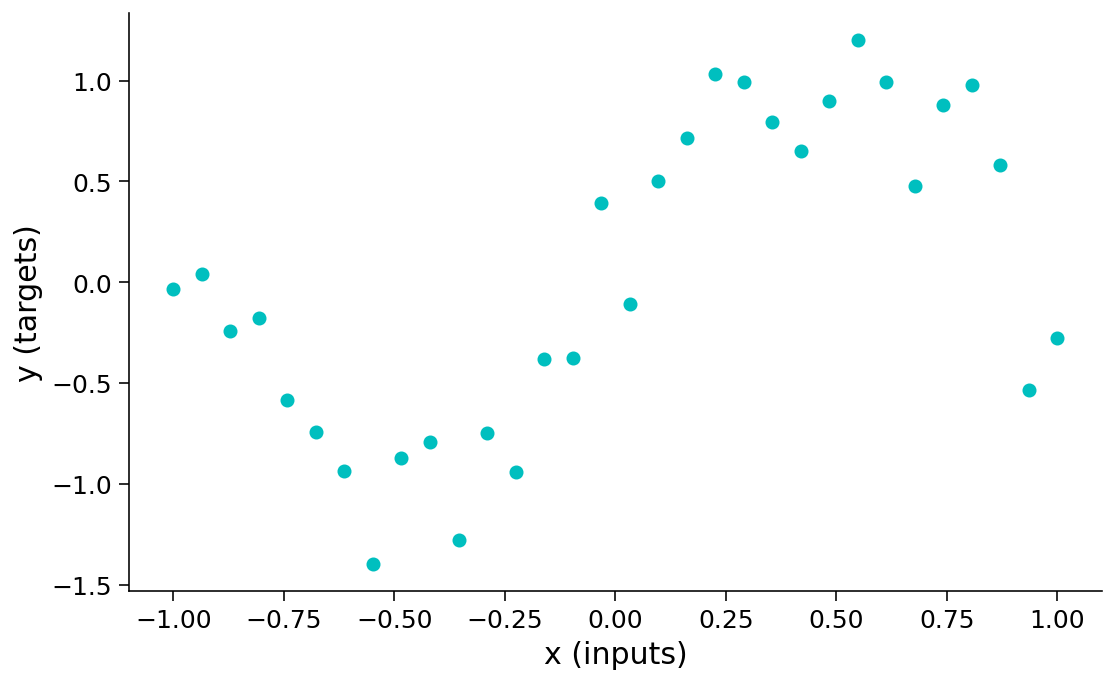

In [7]:
# @markdown #### Generar el conjunto de datos de muestra
set_seed(seed=SEED)
n_samples = 32
inputs = torch.linspace(-1.0, 1.0, n_samples).reshape(n_samples, 1)
noise = torch.randn(n_samples, 1) / 4
targets = torch.sin(pi * inputs) + noise
plt.figure(figsize=(8, 5))
plt.scatter(inputs, targets, c='c')
plt.xlabel('x (inputs)')
plt.ylabel('y (targets)')
plt.show()

Vamos a definir una red neuronal muy amplia (512 neuronas) con una capa oculta y la función de activación `nn.Tanh()`.

In [ ]:
class WideNet(nn.Module):
  """
   A Wide neural network with a single hidden layer
   Structure is as follows:
   nn.Sequential(
        nn.Linear(1, n_cells) + nn.Tanh(), # Fully connected layer with tanh activation
        nn.Linear(n_cells, 1) # Final fully connected layer
    )
  """

  def __init__(self):
    """
    Initializing the parameters of WideNet

    Args:
      None

    Returns:
      Nothing
    """
    n_cells = 512
    super().__init__()
    self.layers = nn.Sequential(
        nn.Linear(1, n_cells),
        nn.Tanh(),
        nn.Linear(n_cells, 1),
    )

  def forward(self, x):
    """
    Forward pass of WideNet

    Args:
      x: torch.Tensor
        2D tensor of features

    Returns:
      Torch tensor of model predictions
    """
    return self.layers(x)

Ahora podemos crear una instancia de nuestra red neuronal e imprimir sus parámetros.

In [ ]:
# Creating an instance
set_seed(seed=SEED)
wide_net = WideNet()
print(wide_net)

In [ ]:
# Create a mse loss function
loss_function = nn.MSELoss()

# Stochstic Gradient Descent optimizer (you will learn about momentum soon)
lr = 0.003  # Learning rate
sgd_optimizer = torch.optim.SGD(wide_net.parameters(), lr=lr, momentum=0.9)

El proceso de entrenamiento en PyTorch es interactivo - puedes realizar iteraciones de entrenamiento como quieras e inspeccionar los resultados después de cada iteración. 

Vamos a realizar una iteración de entrenamiento. Puedes ejecutar la celda varias veces y ver cómo se actualizan los parámetros y se reduce la pérdida. Este bloque de código es el núcleo de todo lo que viene: por favor, asegúrese de ir línea por línea a través de todos los comandos.

In [ ]:
# Reset all gradients to zero
sgd_optimizer.zero_grad()

# Forward pass (Compute the output of the model on the features (inputs))
prediction = wide_net(inputs)

# Compute the loss
loss = loss_function(prediction, targets)
print(f'Loss: {loss.item()}')

# Perform backpropagation to build the graph and compute the gradients
loss.backward()

# Optimizer takes a tiny step in the steepest direction (negative of gradient)
# and "updates" the weights and biases of the network
sgd_optimizer.step()

### Ejercicio: Bucle de formación
Utilizando todo lo que hemos aprendido hasta ahora, te pedimos que completes la función de `entrenamiento` que aparece a continuación.

In [ ]:
def train(features, labels, model, loss_fun, optimizer, n_epochs):
  """
  Training function

  Args:
    features: torch.Tensor
      Features (input) with shape torch.Size([n_samples, 1])
    labels: torch.Tensor
      Labels (targets) with shape torch.Size([n_samples, 1])
    model: torch nn.Module
      The neural network
    loss_fun: function
      Loss function
    optimizer: function
      Optimizer
    n_epochs: int
      Number of training iterations

  Returns:
    loss_record: list
      Record (evolution) of training losses
  """
  loss_record = []  # Keeping recods of loss

  for i in range(n_epochs):
    #################################################
    ## Implement the missing parts of the training loop
    # Complete the function and remove or comment the line below
    raise NotImplementedError("Training loop `train`")
    #################################################
    ...  # Set gradients to 0
    predictions = ...  # Compute model prediction (output)
    loss = ...  # Compute the loss
    ...  # Compute gradients (backward pass)
    ...  # Update parameters (optimizer takes a step)

    loss_record.append(loss.item())
  return loss_record

set_seed(seed=2021)
epochs = 1847 # Cauchy, Exercices d'analyse et de physique mathematique (1847)
## Uncomment to run
# losses = train(inputs, targets, wide_net, loss_function, sgd_optimizer, epochs)
# ex3_plot(wide_net, inputs, targets, epochs, losses)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W1D2_LinearDeepLearning/solutions/W1D2_Tutorial1_Solution_66cb245e.py)

*Example output:*

<img alt='Solution hint' align='left' width=1696.0 height=544.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W1D2_LinearDeepLearning/static/W1D2_Tutorial1_Solution_66cb245e_1.png>



---
# Resumen

En este tutorial, hemos cubierto uno de los conceptos más básicos del aprendizaje profundo; el grafo computacional y cómo una red aprende mediante el descenso de gradiente y el algoritmo de retropropagación. Todo ello lo hemos visto utilizando módulos de PyTorch y hemos comparado las soluciones analíticas con las proporcionadas directamente por el módulo de PyTorch.